In [ ]:
%pip install sentencepiece

In [ ]:
%pip install transformers torch scikit-learn pandas

In [ ]:
import pandas as pd
import os
from transformers import pipeline
from tqdm import tqdm

# ===== 1. 데이터 로드 =====
print("📂 [1/6] 데이터 로드 중...")
original_path = "./data/review_sentiment.csv"   
save_path = "./data/review_sentiment_auto_save.csv"  

df = pd.read_csv(original_path)
df = df.dropna(subset=["review", "id"])
df["review"] = df["review"].astype(str)

print(f"🔍 전체 리뷰 수: {len(df)}개")

# ===== 2. 이어서 진행할 리뷰 필터링 =====
# (점수 또는 라벨이 NaN이거나 비어있는 경우만)
pending_df = df[
    df["sentiment_score"].isna() | df["sentiment_label"].isna()
].copy()

print(f"✏️ 감성 분석 다시 해야 할 리뷰 수: {len(pending_df)}개")

# ===== 3. 파이프라인 로드 =====
print("📦 [2/6] 번역 및 감성 분석 모델 로드 중...")
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-ko-en", device=0)
sentiment_analyzer = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True,
    device=0
)

# ===== 4. 번역 및 감성 분석 함수 =====
save_every = 500
translated_texts = []
sentiment_scores = []
sentiment_labels = []

print("🚀 [3/6] 감성 분석 시작...")

for idx, (i, row) in enumerate(tqdm(pending_df.iterrows(), total=len(pending_df), desc="🔁 진행 중")):
    try:
        text = row["review"]

        # 번역
        translated = translator(text, max_length=256)[0]["translation_text"]

        # 감성 분석
        result = sentiment_analyzer(translated)[0]
        pos_score = next(score["score"] for score in result if score["label"] == "positive")
        score_100 = round(pos_score * 100, 1)

        pending_df.at[i, "sentiment_score"] = score_100
        pending_df.at[i, "sentiment_label"] = 1 if score_100 >= 50 else 0

    except Exception as e:
        print(f"⚠️ 에러 발생 (index {i}): {e}")
        pending_df.at[i, "sentiment_score"] = None
        pending_df.at[i, "sentiment_label"] = None

    # 500개마다 중간 저장
    if (idx + 1) % save_every == 0 or (idx + 1) == len(pending_df):
        combined = pd.concat([
            df[~df.index.isin(pending_df.index)],  # 완료된 데이터
            pending_df  # 새로 추가된 데이터
        ])
        combined.to_csv(save_path, index=False)
        print(f"💾 임시 저장 완료: {len(combined)}개 저장됨")

# ===== 5. 최종 저장 =====
print("✅ [6/6] 전체 감성 분석 및 저장 완료! →", save_path)


In [6]:
import pandas as pd

# 1. 리뷰별 감성 점수 로드
review_df = pd.read_csv("./data/review_sentiment.csv")

# 2. 상품별 평균 감성 점수 계산
product_avg = review_df.groupby("id")["sentiment_score"].mean().reset_index()

# 3. 컬럼명 정리
product_avg.columns = ["product_id", "avg_sentiment_score"]

# 4. 감성 점수 스케일 조정
product_avg["avg_sentiment_score"] = (product_avg["avg_sentiment_score"]).round(1)

# 5. 긍부정 라벨링 추가 (50점 이상이면 긍정(1), 아니면 부정(0))
product_avg["sentiment_label"] = (product_avg["avg_sentiment_score"] >= 50).astype(int)
product_avg.head(5)


,product_id,avg_sentiment_score,sentiment_label
0,47144,71.3,1
1,76867,58.8,1
2,102618,71.8,1
3,102619,69.1,1
4,102620,72.2,1


In [7]:
# 6. CSV 파일로 저장
product_avg.to_csv("./data/product_sentiment.csv", index=False)

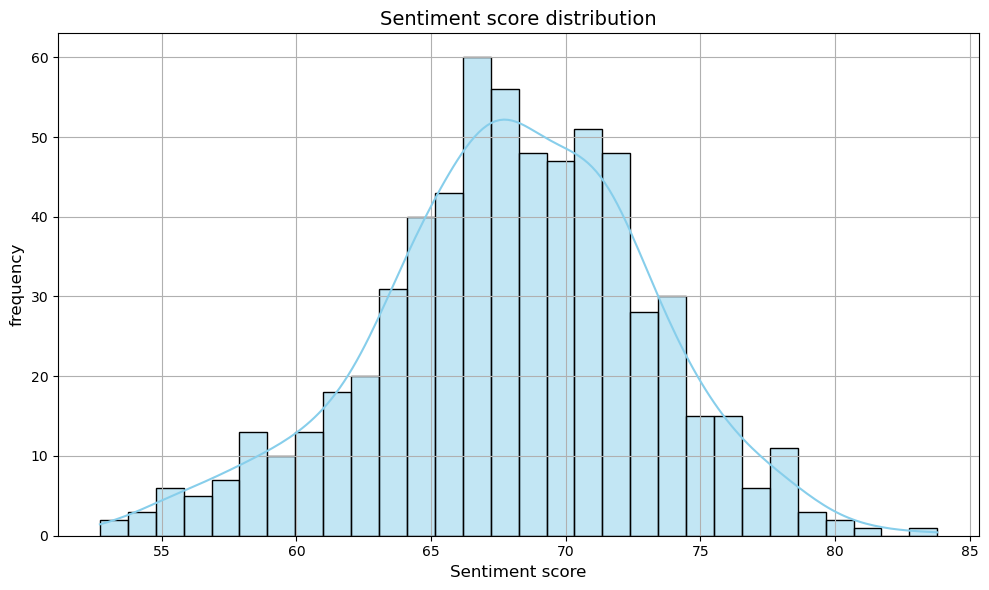

,product_id,avg_sentiment_score,sentiment_label
count,6.330000e+02,633.000000,633.0
mean,2.343305e+06,67.969352,1.0
std,1.152121e+06,5.087890,0.0
min,4.714400e+04,52.700000,1.0
25%,1.420798e+06,64.800000,1.0
50%,2.355318e+06,68.100000,1.0
75%,3.252782e+06,71.400000,1.0
max,4.680101e+06,83.800000,1.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 감성 분석 결과 로드
df = pd.read_csv("./data/product_sentiment.csv")
result = df.describe()

# 2. 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df["avg_sentiment_score"], bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title("Sentiment score distribution", fontsize=14)
plt.xlabel("Sentiment score", fontsize=12)
plt.ylabel("frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

result